In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/My Drive/NASA Airathon')

In [ ]:
# EXPERIMENTAL

In [ ]:
allGrids = pd.read_csv('grid_metadata.csv')

In [ ]:
allGrids = allGrids.grid_id

# **Preprocessing**




# MAIAC Processing


In [ ]:
#@title Install pyhdf and upgrade numpy
!pip install pyhdf
!pip install --upgrade numpy
!pip install pyproj CRS
!pip install pyproj Proj
!pip install pyproj
!pip install geopandas

     |████████████████████████████████| 757 kB 4.3 MB/s 
     |████████████████████████████████| 6.3 MB 4.2 MB/s 
     |████████████████████████████████| 64 kB 1.8 MB/s 
     |████████████████████████████████| 1.0 MB 4.3 MB/s 
     |████████████████████████████████| 16.7 MB 37.6 MB/s 


In [ ]:
from pyhdf.SD import SD, SDC, SDS
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pprint
import os
import cv2
#import cartopy.crs as ccrs
from typing import Dict, List, Union
import pyproj
from pyproj import CRS, Proj

import geopandas as gpd

In [ ]:
import pandas as pd

In [ ]:
fileName = '20180202T195000_maiac_la_0.hdf'

In [ ]:
file_path = './train/maiac/2018/20180202T195000_maiac_la_0'

In [ ]:
file = SD('./train/maiac/2018/20180202T195000_maiac_la_0.hdf', SDC.READ)

In [ ]:
raw_attr = file.attributes()["StructMetadata.0"]
print(raw_attr)

In [ ]:
blue_band_AOD = file.select("Optical_Depth_047")

In [ ]:
len(blue_band_AOD[:])

4

In [ ]:
name, num_dim, shape, types, num_attr = blue_band_AOD.info()
calibration_dict = blue_band_AOD.attributes()

In [ ]:
# Construct grid metadata from text blob
group_1 = raw_attr.split("END_GROUP=GRID_1")[0]
hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])

# Parse expressions still wrapped in apostrophes
for key, val in hdf_metadata.items():
    try:
        hdf_metadata[key] = eval(val)
    except:
        pass

hdf_metadata

{'DataFieldName': 'Injection_Height',
 'DataType': 'DFNT_FLOAT32',
 'DimList': ('Orbits', 'YDim', 'XDim'),
 'DimensionName': 'Orbits',
 'END_GROUP': 'MergedFields',
 'END_OBJECT': 'DataField_8',
 'GROUP': 'MergedFields',
 'GridName': 'grid1km',
 'GridOrigin': 'HDFE_GD_UL',
 'LowerRightMtrs': (-10007554.677, 3335851.559),
 'OBJECT': 'DataField_8',
 'ProjParams': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 'Projection': 'GCTP_SNSOID',
 'Size': 4,
 'SphereCode': -1,
 'UpperLeftPointMtrs': (-11119505.196667, 4447802.078667),
 'XDim': 1200,
 'YDim': 1200}

In [ ]:
# Note that coordinates are provided in meters
alignment_dict = {
    "upper_left": hdf_metadata["UpperLeftPointMtrs"],
    "lower_right": hdf_metadata["LowerRightMtrs"],
    "crs": hdf_metadata["Projection"],
    "crs_params": hdf_metadata["ProjParams"]
}
alignment_dict

{'crs': 'GCTP_SNSOID',
 'crs_params': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 'lower_right': (-10007554.677, 3335851.559),
 'upper_left': (-11119505.196667, 4447802.078667)}

In [ ]:
# Loop over orbits to apply the attributes
def calibrate_data(dataset: SDS, shape: List[int], calibration_dict: Dict):
    """Given a MAIAC dataset and calibration parameters, return a masked
    array of calibrated data.
    
    Args:
        dataset (SDS): dataset in SDS format (e.g. blue band AOD).
        shape (List[int]): dataset shape as a list of [orbits, height, width].
        calibration_dict (Dict): dictionary containing, at a minimum,
            `valid_range` (list or tuple), `_FillValue` (int or float),
            `add_offset` (float), and `scale_factor` (float).
    
    Returns:
        corrected_AOD (np.ma.MaskedArray): masked array of calibrated data
            with a fill value of nan.
    """
    corrected_AOD = np.ma.empty(shape, dtype=np.double)
    for orbit in range(shape[0]):
        data = dataset[orbit, :, :].astype(np.double)
        invalid_condition = (
            (data < calibration_dict["valid_range"][0]) |
            (data > calibration_dict["valid_range"][1]) |
            (data == calibration_dict["_FillValue"])
        )
        data[invalid_condition] = np.nan
        data = (
            (data - calibration_dict["add_offset"]) *
            calibration_dict["scale_factor"]
        )
        data = np.ma.masked_array(data, np.isnan(data))
        corrected_AOD[orbit, : :] = data
    corrected_AOD.fill_value = np.nan
    return corrected_AOD

In [ ]:
corrected_AOD = calibrate_data(blue_band_AOD, shape, calibration_dict)
corrected_AOD

In [ ]:
#corrected_AOD = np.resize(corrected_AOD, (4, 1200, 1200, 1))

In [ ]:
for d in corrected_AOD:
  plt.imshow(d)
  plt.show()

In [ ]:
#final = np.concatenate((corrected_AOD[0], corrected_AOD[1], corrected_AOD[2], corrected_AOD[3]), 2)
#final

In [ ]:
#final.shape

(1200, 1200, 4)

In [ ]:
pd.DataFrame(corrected_AOD.ravel(), columns=['AOD']).describe()

,AOD
count,1.125744e+06
mean,9.549932e-02
std,6.421262e-02
min,0.000000e+00
25%,4.800000e-02
50%,7.900000e-02
75%,1.260000e-01
max,9.410000e-01


In [ ]:
def create_meshgrid(alignment_dict: Dict, shape: List[int]):
    """Given an image shape, create a meshgrid of points
    between bounding coordinates.
    
    Args:
        alignment_dict (Dict): dictionary containing, at a minimum,
            `upper_left` (tuple), `lower_right` (tuple), `crs` (str),
            and `crs_params` (tuple).
        shape (List[int]): dataset shape as a list of
            [orbits, height, width].
    
    Returns:
        xv (np.array): x (longitude) coordinates.
        yv (np.array): y (latitude) coordinates.
    """
    # Determine grid bounds using two coordinates
    x0, y0 = alignment_dict["upper_left"]
    x1, y1 = alignment_dict["lower_right"]
    
    # Interpolate points between corners, inclusive of bounds
    x = np.linspace(x0, x1, shape[2], endpoint=True)
    y = np.linspace(y0, y1, shape[1], endpoint=True)
    
    # Return two 2D arrays representing X & Y coordinates of all points
    xv, yv = np.meshgrid(x, y)
    return xv, yv

In [ ]:
xv, yv = create_meshgrid(alignment_dict, shape)

In [ ]:
def lacoords_maiac(lat_arr, lon_arr):
  #takes lats / lons within range
  lats = np.where((lat_arr >= -11010972.31) & (lat_arr <= -10675914.89))
  lons = np.where((lon_arr >= 3725034.24) & (lon_arr <= 3836229.29))
  maxXLat = np.max(lats[0])
  minXLat = np.min(lats[0])

  maxYLat = np.max(lats[1])
  minYLat = np.min(lats[1])

  maxXLon = np.max(lons[0])
  minXLon = np.min(lons[0])
  
  maxYLon = np.max(lons[1])
  minYLon = np.min(lons[1])
  minX = max(minXLat, minXLon)
  maxX = min(maxXLat, maxXLon)
  minY = max(minYLat, minYLon)
  maxY = min(maxYLat, maxYLon)
  return minX, maxX, minY, maxY

In [ ]:
minX, maxX, minY, maxY = lacoords_maiac(xv, yv)

In [ ]:
print(minX, maxX, minY, maxY)

660 779 118 478


In [ ]:
final_AOD = np.maximum.reduce([blue_band_AOD[0],blue_band_AOD[1], blue_band_AOD[2], blue_band_AOD[3]])

In [ ]:
cropped_final_AOD = final_AOD[minX:maxX, minY:maxY]

In [ ]:
test = cv2.resize(cropped_final_AOD, (100,100))

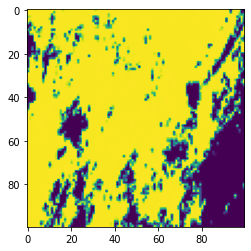

In [ ]:
plt.imshow(test)

In [ ]:
import numpy as np

In [ ]:
maiac = np.empty(shape=(333,100,100,1))
count = 0
for x in sorted(os.listdir("./train/maiac/2018/")):
  if x[-8:-6] == 'la':
    file = SD('./train/maiac/2018/'+x, SDC.READ)
    raw_attr = file.attributes()["StructMetadata.0"]
    blue_band_AOD = file.select("Optical_Depth_047")
    name, num_dim, shape, types, num_attr = blue_band_AOD.info()
    calibration_dict = blue_band_AOD.attributes()
    group_1 = raw_attr.split("END_GROUP=GRID_1")[0]
    hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])
    for key, val in hdf_metadata.items():
        try:
            hdf_metadata[key] = eval(val)
        except:
            pass
    alignment_dict = {
    "upper_left": hdf_metadata["UpperLeftPointMtrs"],
    "lower_right": hdf_metadata["LowerRightMtrs"],
    "crs": hdf_metadata["Projection"],
    "crs_params": hdf_metadata["ProjParams"]
    }
    xv, yv = create_meshgrid(alignment_dict, shape)
    minX, maxX, minY, maxY = lacoords_maiac(xv, yv)
    bands = []
    for i in blue_band_AOD:
      bands.append(i)
    final_AOD = np.maximum.reduce(bands)
    cropped_final_AOD = final_AOD[minX:maxX, minY:maxY]
    aod = cv2.resize(cropped_final_AOD, (100,100))
    out = cv2.resize(aod,(100,100))
    out = np.reshape(out,(100,100,1))
    out = out.clip(min=0)
    maiac[count] = out
    print(count, "images added")
    count = count + 1
    del file

In [ ]:
bands = []
for i in blue_band_AOD:
  bands.append(i)

In [ ]:
bands

[array([[-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        ...,
        [-28672, -28672, -28672, ...,     19,     19,     19],
        [-28672, -28672, -28672, ...,     19,     19,     19],
        [-28672, -28672, -28672, ...,     19,     19,     20]], dtype=int16),
 array([[-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        ...,
        [-28672, -28672, -28672, ...,     40,     39,     37],
        [-28672, -28672, -28672, ...,     35,     38,     36],
        [-28672, -28672, -28672, ...,     23,     23,     20]], dtype=int16),
 array([[-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],

In [ ]:
#aod = np.resize(maiac[180], (100,100))
#plt.imshow(aod)
short_maiac = maiac[0:179]

In [ ]:
np.save("maiac_np", maiac, allow_pickle=True, fix_imports=True)

In [ ]:
maiac = np.load("maiac_la_np.npy", mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [ ]:
len(idxes)

5873

In [ ]:
aod = np.resize(maiac[332], (100, 100))

In [ ]:
maiac_files = []
for x in sorted(os.listdir("./train/maiac/2019/")):
  if x[-8:-6] == 'la':
    maiac_files.append(int(x[0:8]))


In [ ]:
len(maiac_files)

365

In [ ]:
maiac.shape

(1065, 100, 100, 1)

In [ ]:
misr_indexes = np.load("misr_indexes_np.npy")

In [ ]:
misr_indexes

array([  0,   0,   0, ..., 376, 376, 376])

In [ ]:
misr_files = []
misr_files_names = []
for x in sorted(os.listdir("./train/misr/2018/")):
    misr_files.append(int(x[0:8]))
    misr_files_names.append(x)
for x in sorted(os.listdir("./train/misr/2019/")):
    misr_files.append(int(x[0:8]))
    misr_files_names.append(x)
for x in sorted(os.listdir("./train/misr/2020/")):
    misr_files.append(int(x[0:8]))
    misr_files_names.append(x)

In [ ]:
misr_files_names

In [ ]:
submit17

,datetime,grid_id,value
0,2017-01-07T16:00:00Z,1X116,0.0
1,2017-01-07T16:00:00Z,9Q6TA,0.0
2,2017-01-07T16:00:00Z,KW43U,0.0
3,2017-01-07T16:00:00Z,VR4WG,0.0
4,2017-01-07T16:00:00Z,XJF9O,0.0
...,...,...,...
5868,2017-12-31T18:30:00Z,HANW9,0.0
5869,2017-12-31T18:30:00Z,HM74A,0.0
5870,2017-12-31T18:30:00Z,KZ9W9,0.0
5871,2017-12-31T18:30:00Z,P8JA5,0.0


In [ ]:
dates17.unique()

array([20170107, 20170107, 20170107, ..., 20171231, 20171231, 20171231],
      dtype=object)

In [ ]:
dates17 = np.array(submit17.datetime)

In [ ]:
"".join(dates17[0].split("-"))

'20170107T16:00:00Z'

In [ ]:
for i in range(dates17.shape[0]):
  dates17[i] = "".join(dates17[i].split('-'))
  dates17[i] = int(dates17[i][0:8])

In [ ]:
dates

'20171231'

In [ ]:
from datetime import datetime


In [ ]:
dates17.shape

(5873,)

In [ ]:
for i in range(len(maiac_files)):
  maiac_files[i] = maiac_files[i] - 20000

In [ ]:
maiac_files

[20170101,
 20170102,
 20170103,
 20170104,
 20170105,
 20170106,
 20170107,
 20170108,
 20170109,
 20170110,
 20170111,
 20170112,
 20170113,
 20170114,
 20170115,
 20170116,
 20170117,
 20170118,
 20170119,
 20170120,
 20170121,
 20170122,
 20170123,
 20170124,
 20170125,
 20170126,
 20170127,
 20170128,
 20170129,
 20170130,
 20170131,
 20170201,
 20170202,
 20170203,
 20170204,
 20170205,
 20170206,
 20170207,
 20170208,
 20170209,
 20170210,
 20170211,
 20170212,
 20170213,
 20170214,
 20170215,
 20170216,
 20170217,
 20170218,
 20170219,
 20170220,
 20170221,
 20170222,
 20170223,
 20170224,
 20170225,
 20170226,
 20170227,
 20170228,
 20170301,
 20170302,
 20170303,
 20170304,
 20170305,
 20170306,
 20170307,
 20170308,
 20170309,
 20170310,
 20170311,
 20170312,
 20170313,
 20170314,
 20170315,
 20170316,
 20170317,
 20170318,
 20170319,
 20170320,
 20170321,
 20170322,
 20170323,
 20170324,
 20170325,
 20170326,
 20170327,
 20170328,
 20170329,
 20170330,
 20170331,
 20170401,

In [ ]:
print(dates17)

[20170107 20170107 20170107 ... 20171231 20171231 20171231]


In [ ]:
idxes = []
for i in range(dates17.shape[0]):
  idxes.append(closest_value(maiac_files, dates17[i]))

In [ ]:
idxes

[6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 20,
 20,
 20,
 20,
 20,
 

In [ ]:
datesAll = datesAll[np.where(np.char.find(str(datesAll), '2019')>=0)]

In [ ]:
datesAll

array([], dtype=object)

In [ ]:
def closest_value(input_list, input_value):
 
  arr = np.asarray(input_list)
 
  i = (np.abs(arr - input_value)).argmin()
 
  return i


In [ ]:
misr_file_indexes = []
for maiac_file in maiac_files:
  misr_file_indexes.append(closest_value(misr_files, maiac_file))

In [ ]:
misr_file_indexes

In [ ]:
misr.sha

In [ ]:
maiac.shape

(1065, 100, 100, 1)

#Weather Data

In [ ]:
#@title Install matplotlib basemap / pygrib
!apt install proj-bin libproj-dev libgeos-dev
!pip install pyproj pyshp
!pip install https://github.com/matplotlib/basemap/archive/refs/tags/v1.3.1.zip#subdirectory=packages/basemap
!pip install pygrib

In [ ]:
#@title
import pygrib
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from mpl_toolkits.basemap import Basemap, addcyclic
import pandas as pd

%matplotlib inline

In [ ]:
#@title
file = ('./train/weather/gfs_3_20220204_0600_006.grb2')
gr = pygrib.open(file)

In [ ]:
#@title
for g in gr:
    print(g)

In [ ]:
#@title
def grb_to_grid(grb_obj):
    """Takes a single grb object containing multiple
    levels. Assumes same time, pressure levels. Compiles to a cube"""
    n_levels = len(grb_obj)
    levels = np.array([grb_element['level'] for grb_element in grb_obj])
    indexes = np.argsort(levels)[::-1] # highest pressure first
    cube = np.zeros([n_levels, grb_obj[0].values.shape[0], grb_obj[1].values.shape[1]])
    for i in range(n_levels):
        cube[i,:,:] = grb_obj[indexes[i]].values
    cube_dict = {'data' : cube, 'units' : grb_obj[0]['units'],
                 'levels' : levels[indexes]}
    return cube_dict

In [ ]:
#@title
gph = gr.select(name = 'Geopotential Height')

In [ ]:
#@title
grb_cube_height = grb_to_grid(gph)

In [ ]:
#@title
grb_cube_height['data'].shape

(48, 181, 360)

In [ ]:
#@title
grb_cube_height['data']

In [ ]:
#@title
adj_height_cube = grb_cube_height['data'][:,0:180,:]

In [ ]:
#@title
heightlat, heightlon = gph[0].latlons()

In [ ]:
#@title
# Takes all grib messages only associated with wind
uCompWind = gr.select(name='U component of wind')
vCompWind = gr.select(name='V component of wind')

In [ ]:
#@title
uCompWind[0]['validityTime']

1200

In [ ]:
#@title


In [ ]:
#@title
grb_cube_v=grb_to_grid(vCompWind)
grb_cube_u=grb_to_grid(uCompWind)

In [ ]:
#@title
startLong = 0
endLong = 180
startLat = 0
endLat = 360

In [ ]:
#@title
ca_grb_cube_v = grb_cube_u['data'][:,startLong:endLong,startLat:endLat]
ca_grb_cube_u = grb_cube_u['data'][:,startLong:endLong,startLat:endLat]

In [ ]:
#@title
lat = uCompWind[0].latlons()[0][startLong:endLong,startLat:endLat]
lon = uCompWind[0].latlons()[1][startLong:endLong,startLat:endLat]

In [ ]:
#@title
map(0, ca_grb_cube_u, ca_grb_cube_v, lat, lon)

In [ ]:
#@title
def map(messageNumber, u, v, latitude, longitude):
  u_component_of_wind = u[messageNumber]
  u_component_of_wind[u_component_of_wind > 1000] = 0
  v_component_of_wind = v[messageNumber]
  v_component_of_wind[v_component_of_wind > 1000] = 0
  # Creating plot
  fig, ax = plt.subplots(figsize = (12, 7))
  ax.quiver(
    latitude,
    longitude,
    u_component_of_wind,
    v_component_of_wind)
  ax.set_title('Wind map of the world')
  
  # Show plot
  plt.show()

# MISR Data Processing

In [ ]:
import numpy as np
import netCDF4 as nc
from matplotlib import pyplot as plt
from matplotlib import colors

In [ ]:
modisFile = './train/misr/2018/20180201T031746_misr_tpe_0.nc'

In [ ]:
ds = nc.Dataset(modisFile)

In [ ]:
misrAod = ds.groups['4.4_KM_PRODUCTS'].variables['Absorption_Aerosol_Optical_Depth'][:]

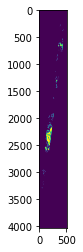

In [ ]:
plt.imshow(misrAod.data)

In [ ]:
lat_arr = ds.groups['4.4_KM_PRODUCTS'].variables['Latitude'][:]
lon_arr = ds.groups['4.4_KM_PRODUCTS'].variables['Longitude'][:]

In [ ]:
741-781, 419-356

(-40, 63)

In [ ]:
lats = np.where((lat_arr >= 33.5) & (lat_arr <= 34.5))
lons = np.where((lon_arr >= -118.75) & (lon_arr <= -117.5))

In [ ]:
lats, lons

((array([741, 741, 742, ..., 781, 781, 781]),
  array([438, 439, 431, ..., 314, 315, 316])),
 (array([], dtype=int64), array([], dtype=int64)))

In [ ]:
maxXLat = np.amax(lats[0])
minXLat = np.amin(lats[0])
maxYLat = np.amax(lats[1])
minYLat = np.amin(lats[1])

In [ ]:
maxXLon = np.amax(lons[0])
minXLon = np.amin(lons[0])
maxYLon = np.amax(lons[1])
minYLon = np.amin(lons[1])

In [ ]:
minX = max(minXLat, minXLon)
maxX = min(maxXLat, maxXLon)
minY = max(minYLat, minYLon)
maxY = min(maxYLat, maxYLon)

In [ ]:
minX, maxX, minY, maxY

In [ ]:
def lacoords(lat_arr, lon_arr):
  lats = np.where((lat_arr >= 33.5) & (lat_arr <= 34.5))
  lons = np.where((lon_arr >= -118.75) & (lon_arr <= -116.5))
  maxXLat = np.max(lats[0])
  minXLat = np.min(lats[0])
  maxYLat = np.max(lats[1])
  minYLat = np.min(lats[1])
  maxXLon = np.max(lons[0])
  minXLon = np.min(lons[0])
  maxYLon = np.max(lons[1])
  minYLon = np.min(lons[1])
  minX = max(minXLat, minXLon)
  maxX = min(maxXLat, maxXLon)
  minY = max(minYLat, minYLon)
  maxY = min(maxYLat, maxYLon)
  return minX, maxX, minY, maxY

In [ ]:
lacoords(lat_arr, lon_arr)

(741, 781, 349, 431)

In [ ]:
type(misr_files_names[0])

str

In [ ]:
misr = np.empty(shape=(333,100,100,1))
count = 0
for x in sorted(os.listdir("./train/misr/2018/")):
  if (x[-7:-5] == 'la'):
    ds = nc.Dataset('./train/misr/2018/'+x)
    misrAod = ds.groups['4.4_KM_PRODUCTS'].variables['Absorption_Aerosol_Optical_Depth'][:]
    lat_arr = ds.groups['4.4_KM_PRODUCTS'].variables['Latitude'][:]
    lon_arr = ds.groups['4.4_KM_PRODUCTS'].variables['Longitude'][:]
    minX, maxX, minY, maxY = lacoords(lat_arr, lon_arr)
    aod = np.power(misrAod.clip(min=0).data[minX:maxX, minY:maxY],(.25))
    aod = cv2.resize(aod, (100,100))
    aod = np.reshape(aod,(100,100,1))
    misr[count] = aod
    count += 1
    print(count, "images added")
    del ds

In [ ]:
clouds = np.resize(misr[0], (100,100))

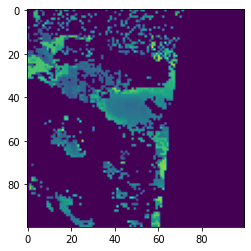

In [ ]:
plt.imshow(clouds)

In [ ]:
np.save("misr_np", misr, allow_pickle=True, fix_imports=True)

In [ ]:
misr_np = np.load("misr_la_np.npy", mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [ ]:
misr_indexes.shape

(1065,)

In [ ]:
misr = np.empty(shape=(1065,100,100,1))
count = 0
for x in misr_indexes:
  misr[count] = misr_np[x]
  count += 1

In [ ]:
misr.shape

(1065, 100, 100, 1)

In [ ]:
maiac.shape

(1065, 100, 100, 1)

In [ ]:
maiac.shape

(333, 100, 100, 1)

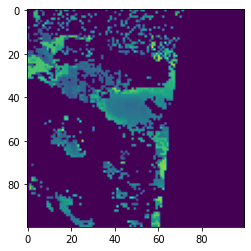

In [ ]:
plt.imshow(misr[0,:,:,0])

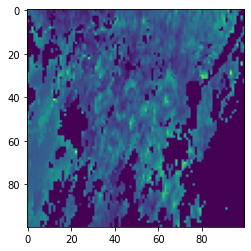

In [ ]:
plt.imshow(maiac[0,:,:,0])

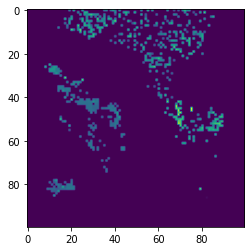

In [ ]:
aod = np.reshape(misr[52],(100,100))
plt.imshow(aod)

# NASA Digital Elevation Model (NASADEM) Dataset


In [ ]:
!pip install pystac-client
!pip install datashader
!pip install planetary_computer
!pip install xarray

In [ ]:
#@title Experimental Code

from pystac_client import Client

catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

collections = catalog.get_children()
for collection in collections:
    print(f"{collection.id} - {collection.title}")

nasadem = catalog.get_child("nasadem")
for band in nasadem.extra_fields["summaries"]["eo:bands"]:
    name = band["name"]
    description = band["description"]
    common_name = "" if "common_name" not in band else f"({band['common_name']})"
    ground_sample_distance = band["gsd"]
    print(f"{name} {common_name}: {description} ({ground_sample_distance}m resolution)")

In [ ]:
from datashader.transfer_functions import shade, stack
from datashader.colors import Elevation
from pystac_client import Client

import planetary_computer as pc
import xarray as xr

In [ ]:
#@title
# Specify coordinates for areas of interest: obtained from grid_metadata.csv
la_aoi = {
    "type": "MultiPolygon",
    "coordinates": [
        [[
[-117.9338248256995, 33.79558357488509],
[-117.9338248256995, 33.83290166381627], 
[-117.9787405899055, 33.83290166381627],
[-117.9787405899055, 33.79558357488509], 
[-117.9338248256995, 33.79558357488509]
        ]],

        [[
[-117.3948356552278, 33.98201108613195], 
[-117.3948356552278, 34.01924766510738], 
[-117.4397514194338, 34.01924766510738], 
[-117.4397514194338, 33.98201108613195], 
[-117.3948356552278, 33.98201108613195]
        ]],

        [[
[-118.3380667035533, 34.16803061743935], 
[-118.3380667035533, 34.20518547216206], 
[-118.3829824677593, 34.20518547216206], 
[-118.3829824677593, 34.16803061743935], 
[-118.3380667035533, 34.16803061743935]
        ]],

        [[
[-117.6194144762577, 34.09367183102137], 
[-117.6194144762577, 34.13085940091023], 
[-117.6643302404637, 34.13085940091023], 
[-117.6643302404637, 34.09367183102137], 
[-117.6194144762577, 34.09367183102137]
        ]],

        [[
[-117.4846671836398, 33.98201108613195], 
[-117.4846671836398, 34.01924766510738], 
[-117.5295829478457, 34.01924766510738], 
[-117.5295829478457, 33.98201108613195], 
[-117.4846671836398, 33.98201108613195]
        ]],

        [[
[-118.1584036467294, 33.83290166381627], 
[-118.1584036467294, 33.87020346808818], 
[-118.2033194109354, 33.87020346808818], 
[-118.2033194109354, 33.83290166381627], 
[-118.1584036467294, 33.83290166381627]
        ]],

        [[
[-118.5177297603772, 34.16803061743935],
[-118.5177297603772, 34.20518547216206], 
[-118.5626455245832, 34.20518547216206], 
[-118.5626455245832, 34.16803061743935], 
[-118.5177297603772, 34.16803061743935]
        ]],

        [[
[-118.2033194109354, 34.05646791625069], 
[-118.2033194109354, 34.09367183102137], 
[-118.2482351751414, 34.09367183102137], 
[-118.2482351751414, 34.05646791625069], 
[-118.2033194109354, 34.05646791625069]
        ]],

        [[
[-118.5177297603772, 34.35364110514904], 
[-118.5177297603772, 34.39071402523285], 
[-118.5626455245832, 34.39071402523285],
[-118.5626455245832, 34.35364110514904], 
[-118.5177297603772, 34.35364110514904]
        ]],

        [[
[-118.2033194109354, 33.87020346808818],
[-118.2033194109354, 33.9074889790035], 
[-118.2482351751414, 33.9074889790035], 
[-118.2482351751414, 33.87020346808818], 
[-118.2033194109354, 33.87020346808818]
        ]],

        [[
[-116.8558464847561, 33.9074889790035], 
[-116.8558464847561, 33.94475818789627], 
[-116.9007622489621, 33.94475818789627], 
[-116.9007622489621, 33.9074889790035], 
[-116.8558464847561, 33.9074889790035]
        ]],

        [[
[-117.5744987120517, 34.01924766510738], 
[-117.5744987120517, 34.05646791625069],
[-117.6194144762577, 34.05646791625069], 
[-117.6194144762577, 34.01924766510738], 
[-117.5744987120517, 34.01924766510738]
        ]],

        [[
[-117.8439932972876, 34.13085940091023], 
[-117.8439932972876, 34.16803061743935], 
[-117.8889090614936, 34.16803061743935],
[-117.8889090614936, 34.13085940091023], 
[-117.8439932972876, 34.13085940091023]
        ]],

        [[
[-117.3050041268159, 33.64614854761477], 
[-117.3050041268159, 33.68353168758084], 
[-117.3499198910219, 33.68353168758084], 
[-117.3499198910219, 33.64614854761477], 
[-117.3050041268159, 33.64614854761477]
        ]]
    ],
}

taipei_aoi = {
    "type": "MultiPolygon",
    "coordinates": [
    [[
[121.5257644471362, 24.97766123020391],
[121.5257644471362, 25.01836939334328], 
[121.4808486829302, 25.01836939334328], 
[121.4808486829302, 24.97766123020391], 
[121.5257644471362, 24.97766123020391]
    ]],

    [[
[121.5706802113421, 25.01836939334328],
[121.5706802113421, 25.05906406274214],
[121.5257644471362, 25.05906406274214], 
[121.5257644471362, 25.01836939334328], 
[121.5706802113421, 25.01836939334328]
    ]],

    [[
[121.5706802113421, 25.05906406274214], 
[121.5706802113421, 25.09974522235117], 
[121.5257644471362, 25.09974522235117], 
[121.5257644471362, 25.05906406274214], 
[121.5706802113421, 25.05906406274214]
    ]],

    [[
[121.6155959755481, 25.01836939334328], 
[121.6155959755481, 25.05906406274214], 
[121.5706802113421, 25.05906406274214], 
[121.5706802113421, 25.01836939334328], 
[121.6155959755481, 25.01836939334328]
    ]],

    [[
[121.5257644471362, 25.05906406274214], 
[121.5257644471362, 25.09974522235117], 
[121.4808486829302, 25.09974522235117], 
[121.4808486829302, 25.05906406274214], 
[121.5257644471362, 25.05906406274214]
    ]],

    [[
[121.5257644471362, 25.01836939334328], 
[121.5257644471362, 25.05906406274214], 
[121.4808486829302, 25.05906406274214], 
[121.4808486829302, 25.01836939334328], 
[121.5257644471362, 25.01836939334328]
    ]],

    [[
[121.5257644471362, 25.09974522235117], 
[121.5257644471362, 25.14041285615363], 
[121.4808486829302, 25.14041285615363], 
[121.4808486829302, 25.09974522235117], 
[121.5257644471362, 25.09974522235117]
    ]],

    ]
}

dehli_aoi = {
  "type": "MultiPolygon",
  "coordinates": [
  [[
[77.30453178416276, 28.54664454217707], 
[77.30453178416276, 28.58609243100243], 
[77.25961601995678, 28.58609243100243], 
[77.25961601995678, 28.54664454217707], 
[77.30453178416276, 28.54664454217707]
  ]],

  [[
[77.07995296313287, 28.54664454217707], 
[77.07995296313287, 28.58609243100243], 
[77.0350371989269, 28.58609243100243], 
[77.0350371989269, 28.54664454217707], 
[77.07995296313287, 28.54664454217707]
  ]],

  [[
[77.12486872733885, 28.54664454217707], 
[77.12486872733885, 28.58609243100243], 
[77.07995296313287, 28.58609243100243], 
[77.07995296313287, 28.54664454217707], 
[77.12486872733885, 28.54664454217707]
  ]],

  [[
[76.94520567051495, 28.54664454217707], 
[76.94520567051495, 28.58609243100243], 
[76.90028990630897, 28.58609243100243], 
[76.90028990630897, 28.54664454217707], 
[76.94520567051495, 28.54664454217707]
  ]],

  [[
[77.12486872733885, 28.58609243100243], 
[77.12486872733885, 28.62552552598286], 
[77.07995296313287, 28.62552552598286], 
[77.07995296313287, 28.58609243100243], 
[77.12486872733885, 28.58609243100243]
  ]],

  [[
[77.30453178416276, 28.46770443564941], 
[77.30453178416276, 28.50718187266299], 
[77.25961601995678, 28.50718187266299], 
[77.25961601995678, 28.46770443564941], 
[77.30453178416276, 28.46770443564941]
  ]],

  [[
[77.21470025575081, 28.62552552598286], 
[77.21470025575081, 28.66494381399507], 
[77.16978449154482, 28.66494381399507], 
[77.16978449154482, 28.62552552598286], 
[77.21470025575081, 28.62552552598286]
  ]],

  [[
[77.25961601995678, 28.58609243100243], 
[77.25961601995678, 28.62552552598286], 
[77.21470025575081, 28.62552552598286], 
[77.21470025575081, 28.58609243100243], 
[77.25961601995678, 28.58609243100243]
  ]],

  [[
[77.25961601995678, 28.70434728194878], 
[77.25961601995678, 28.74373591678664], 
[77.21470025575081, 28.74373591678664], 
[77.21470025575081, 28.70434728194878], 
[77.25961601995678, 28.70434728194878]
  ]],

  [[
[77.21470025575081, 28.50718187266299], 
[77.21470025575081, 28.54664454217707], 
[77.16978449154482, 28.54664454217707], 
[77.16978449154482, 28.50718187266299], 
[77.21470025575081, 28.50718187266299]
  ]],

  [[
[77.30453178416276, 28.66494381399507], 
[77.30453178416276, 28.70434728194878], 
[77.25961601995678, 28.70434728194878], 
[77.25961601995678, 28.66494381399507], 
[77.30453178416276, 28.66494381399507]
  ]],

  [[
[77.16978449154482, 28.70434728194878], 
[77.16978449154482, 28.74373591678664], 
[77.12486872733885, 28.74373591678664], 
[77.12486872733885, 28.70434728194878], 
[77.16978449154482, 28.70434728194878]
  ]],

  [[
[77.34944754836873, 28.66494381399507], 
[77.34944754836873, 28.70434728194878], 
[77.30453178416276, 28.70434728194878], 
[77.30453178416276, 28.66494381399507], 
[77.34944754836873, 28.66494381399507]
  ]],

  [[
[77.0350371989269, 28.58609243100243], 
[77.0350371989269, 28.62552552598286], 
[76.99012143472092, 28.62552552598286], 
[76.99012143472092, 28.58609243100243], 
[77.0350371989269, 28.58609243100243]
  ]],

  [[
[77.12486872733885, 28.74373591678664], 
[77.12486872733885, 28.7831097054843], 
[77.07995296313287, 28.7831097054843], 
[77.07995296313287, 28.74373591678664], 
[77.12486872733885, 28.74373591678664]
  ]],

  [[
[77.12486872733885, 28.46770443564941], 
[77.12486872733885, 28.50718187266299], 
[77.07995296313287, 28.50718187266299], 
[77.07995296313287, 28.46770443564941], 
[77.12486872733885, 28.46770443564941]
  ]],

  [[
[77.21470025575081, 28.66494381399507], 
[77.21470025575081, 28.70434728194878], 
[77.16978449154482, 28.70434728194878], 
[77.16978449154482, 28.66494381399507], 
[77.21470025575081, 28.66494381399507]
  ]],

  [[
[77.21470025575081, 28.54664454217707], 
[77.21470025575081, 28.58609243100243], 
[77.16978449154482, 28.58609243100243], 
[77.16978449154482, 28.54664454217707], 
[77.21470025575081, 28.54664454217707]
  ]],

  [[
[77.12486872733885, 28.66494381399507], 
[77.12486872733885, 28.70434728194878], 
[77.07995296313287, 28.70434728194878], 
[77.07995296313287, 28.66494381399507], 
[77.12486872733885, 28.66494381399507]
  ]],

  [[
[77.25961601995678, 28.62552552598286], 
[77.25961601995678, 28.66494381399507], 
[77.21470025575081, 28.66494381399507], 
[77.21470025575081, 28.62552552598286], 
[77.25961601995678, 28.62552552598286]
  ]],

  [[
[77.16978449154482, 28.62552552598286], 
[77.16978449154482, 28.66494381399507], 
[77.12486872733885, 28.66494381399507], 
[77.12486872733885, 28.62552552598286], 
[77.16978449154482, 28.62552552598286]
  ]],

  [[
[77.12486872733885, 28.82246863505031], 
[77.12486872733885, 28.86181269252625], 
[77.07995296313287, 28.86181269252625], 
[77.07995296313287, 28.82246863505031], 
[77.12486872733885, 28.82246863505031]
  ]],

  [[
[77.25961601995678, 28.54664454217707], 
[77.25961601995678, 28.58609243100243], 
[77.21470025575081, 28.58609243100243], 
[77.21470025575081, 28.54664454217707], 
[77.25961601995678, 28.54664454217707]
  ]],

  [[
[77.21470025575081, 28.70434728194878], 
[77.21470025575081, 28.74373591678664], 
[77.16978449154482, 28.74373591678664], 
[77.16978449154482, 28.70434728194878], 
[77.21470025575081, 28.70434728194878]
  ]],

  [[
[76.94520567051495, 28.66494381399507], 
[76.94520567051495, 28.70434728194878], 
[76.90028990630897, 28.70434728194878], 
[76.90028990630897, 28.66494381399507], 
[76.94520567051495, 28.66494381399507]
  ]],
   
  [[
[77.07995296313287, 28.70434728194878], 
[77.07995296313287, 28.74373591678664], 
[77.0350371989269, 28.74373591678664], 
[77.0350371989269, 28.70434728194878], 
[77.07995296313287, 28.70434728194878]
  ]],
   
  [[
[77.16978449154482, 28.66494381399507], 
[77.16978449154482, 28.70434728194878], 
[77.12486872733885, 28.70434728194878], 
[77.12486872733885, 28.66494381399507], 
[77.16978449154482, 28.66494381399507]
  ]],
   
  [[
[77.16978449154482, 28.66494381399507], 
[77.16978449154482, 28.70434728194878], 
[77.12486872733885, 28.70434728194878], 
[77.12486872733885, 28.66494381399507], 
[77.16978449154482, 28.66494381399507]
  ]],
  
  [[
[77.16978449154482, 28.7831097054843], 
[77.16978449154482, 28.82246863505031], 
[77.12486872733885, 28.82246863505031], 
[77.12486872733885, 28.7831097054843], 
[77.16978449154482, 28.7831097054843]
  ]],
  
  [[
[77.07995296313287, 28.74373591678664], 
[77.07995296313287, 28.7831097054843], 
[77.0350371989269, 28.7831097054843], 
[77.0350371989269, 28.74373591678664], 
[77.07995296313287, 28.74373591678664]
  ]],
   
  [[
[77.16978449154482, 28.54664454217707], 
[77.16978449154482, 28.58609243100243], 
[77.12486872733885, 28.58609243100243], 
[77.12486872733885, 28.54664454217707], 
[77.16978449154482, 28.54664454217707]
  ]],
  
  [[
[77.30453178416276, 28.62552552598286],
[77.30453178416276, 28.66494381399507], 
[77.25961601995678, 28.66494381399507], 
[77.25961601995678, 28.62552552598286], 
[77.30453178416276, 28.62552552598286]
  ]],
  
  [[
[77.07995296313287, 28.66494381399507], 
[77.07995296313287, 28.70434728194878], 
[77.0350371989269, 28.70434728194878], 
[77.0350371989269, 28.66494381399507], 
[77.07995296313287, 28.66494381399507]
  ]]
  ]
}

time_range = "2020-12-01/2020-12-31"

search = catalog.search(
    collections=["nasadem"], intersects=la_aoi, datetime=time_range
)


In [ ]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
nasadem = catalog.search(collections=["nasadem"], intersects=dehli_aoi)

items = [item for item in nasadem.get_items()]

print(f"Returned {len(items)} Items")

Returned 2 Items


In [ ]:
item = items[0]
print(item.assets)


{'elevation': <Asset href=https://nasademeuwest.blob.core.windows.net/nasadem-cog/v001/NASADEM_HGT_n28e077.tif>, 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=nasadem&item=NASADEM_HGT_n28e077&assets=elevation&colormap_name=terrain&rescale=-100,4000>, 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=nasadem&item=NASADEM_HGT_n28e077&assets=elevation&colormap_name=terrain&rescale=-100,4000>}


In [ ]:
link = 'https://nasademeuwest.blob.core.windows.net/nasadem-cog/v001/NASADEM_HGT_n28e077.tif'

In [ ]:
import requests


url = link
r = requests.get(url, allow_redirects=True)

open('NASADEM_HGT_n28e077.tif', 'wb').write(r.content)

7846368

In [ ]:
items = list(catalog.get_all_items())

print(f"Number of items: {len(items)}")
for item in items:
  print(f"- {item.id}")

In [ ]:
maiac.shape

(339, 100, 100, 1)

In [ ]:
misr.shape

(111, 100, 100, 1)

In [ ]:
data = np.concatenate([maiac,misr], axis=3)

ValueError: ignored

# ECMWF IFS CY41r2 High-Resolution Operational Forecasts

The Integrated Forecast System (IFS) model cycle CY41r2 High-Resolution Operational Forecast is a dataset by the European Centre for Medium-Range Weather Forecasts (ECMWF). It provides highly accurate weather forecasts with a nominal grid point spacing of nine kilometers.

Note that the approved data access location is accessible via NCAR servers, which requires registration.

DATASET USED: ECMWF Operational 6-hourly atmospheric surface forecast	(https://rda.ucar.edu/thredds/catalog/files/g/ds113.1/ec.oper.fc.sfc/catalog.html)

In [ ]:
#@title Accessing via Jupyter Notebook Download Script on Command Line
set filelist = ( \
  /gpfs/fs1/collections/rda/data/ds113.1/ec.oper.fc.sfc/201601/ec.oper.fc.sfc.128_031_ci.regn1280sc.20160101.grb \
)

while($#filelist > 0)
  echo "cp -f $filelist[1]"
  cp -f $filelist[1] ./ 

  shift filelist
end

exit 0

In [ ]:
#@title Accessing via Siphon API
!pip install Siphon
!pip install ipywidgets 

In [ ]:
from siphon.catalog import TDSCatalog
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets

In [ ]:
date = np.arange('2018-02','2021-01', dtype='datetime64[D]')
ts = pd.to_datetime(date) 
URLParam = ts.strftime('%Y%m')
datasetNameParam = ts.strftime('%Y%m%d')

In [ ]:
datasetNameParam[1000]

'20201028'

In [ ]:
catUrl = 'https://rda.ucar.edu/thredds/catalog/files/g/ds113.1/ec.oper.fc.sfc/201802/catalog.xml'
datasetName = 'ec.oper.fc.sfc.128_165_10u.regn1280sc.20180201.nc'

In [ ]:
catalog = TDSCatalog(catUrl)

In [ ]:
ds = catalog.datasets[datasetName]
nc = ds.remote_access()

In [ ]:
nc.variables

OrderedDict([('VAR_10U', <siphon.cdmr.dataset.Variable at 0x7fc6439e6190>),
             ('forecast_hour',
              <siphon.cdmr.dataset.Variable at 0x7fc6439e6350>),
             ('forecast_initial_time',
              <siphon.cdmr.dataset.Variable at 0x7fc6439e6690>),
             ('latitude', <siphon.cdmr.dataset.Variable at 0x7fc642d07f10>),
             ('longitude', <siphon.cdmr.dataset.Variable at 0x7fc642d7fb50>),
             ('utc_date', <siphon.cdmr.dataset.Variable at 0x7fc642d7fd50>)])

In [ ]:
w_d = nc.variables['VAR_10U']
print(w_d)

<class 'siphon.cdmr.dataset.Variable'>
float32 VAR_10U(forecast_initial_time, forecast_hour, latitude, longitude)
	long_name: 10 metre U wind component
	short_name: 10u
	units: m s**-1
	original_format: WMO GRIB 1 with ECMWF local table
	ecmwf_local_table: 128
	ecmwf_parameter: 165
	_FillValue: 9.999000260554009e+20
	missing_value: 9.999000260554009e+20
	data_min: -40.360015869140625
	data_max: 40.198577880859375
	grid_specification: 5120 longitude x 2560 Gaussian latitude (0.07deg x ~0.07deg from 0E to 359.93E and 89.946N to 89.946S)
	original_data_representation: Reduced Gaussian grid (N1280)
	rda_dataset: ds113.1
	rda_dataset_url: https:/rda.ucar.edu/datasets/ds113.1/
	rda_dataset_doi: DOI: 10.5065/D68050ZV
	rda_dataset_group: ECMWF Operational 6-hourly atmospheric surface forecast
	number_of_significant_digits: 7
	_ChunkSizes: [   1    2 2560 5120]
shape = (2, 2, 2560, 5120)


In [ ]:
w_d[0,0]

array([[ 0.3773651 ,  0.37345886,  0.37150574, ...,  0.3851776 ,
         0.3832245 ,  0.37931824],
       [ 0.3461151 ,  0.34220886,  0.34025574, ...,  0.3539276 ,
         0.3519745 ,  0.34806824],
       [ 0.2523651 ,  0.24845886,  0.24650574, ...,  0.2601776 ,
         0.25627136,  0.25431824],
       ...,
       [-2.499588  , -2.497635  , -2.4956818 , ..., -2.5034943 ,
        -2.5034943 , -2.5015411 ],
       [-2.4136505 , -2.4116974 , -2.4097443 , ..., -2.4175568 ,
        -2.4156036 , -2.4156036 ],
       [-2.343338  , -2.341385  , -2.3394318 , ..., -2.3472443 ,
        -2.3452911 , -2.3452911 ]], dtype=float32)

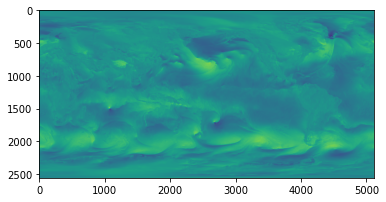

In [ ]:
plt.imshow(w_d[0,0])

In [ ]:
import numpy as np

In [ ]:
#create empty numpy array for each feature
feature_names = ["u_comp_of_wind", "v_comp_of_wind", "total_precipitation", "top_solar_radiation", "surface_solar_radiation", "evaporation", "total_cloud_cover", "surface_pressure", "two_metre_temperature", "total_column_ozone", "total_column_water_vapor"]
np_array_names = ["u_comp_of_wind_np", "v_comp_of_wind_np", "total_precipitation_np", "top_solar_radiation_np", "surface_solar_radiation_np", "evaporation_np", "total_cloud_cover_np", "surface_pressure_np", "two_metre_temperature_np", "total_column_ozone_np", "total_column_water_vapor_np"]
for i in range(0, len(np_array_names)):
  np_array_names[i] = np.empty(shape = (1065, 100, 100, 1))


In [ ]:
ds_features = ["165_10u", "166_10v", "228_tp", "178_tsr", "176_ssr", "182_e", "164_tcc", "134_sp", "167_2t", "206_tco3", "137_tcwv"]
# For loop should populate numpy array
# Iterates through each file and crops it to 100x100 grid
for i in range(0,1): #change range to 0-1065 days
  catUrl = f'https://rda.ucar.edu/thredds/catalog/files/g/ds113.1/ec.oper.fc.sfc/{URLParam[i]}/catalog.xml'
  catalog = TDSCatalog(catUrl)
  for j in range(0, len(np_array_names)):
    datasetName = f"ec.oper.fc.sfc.128_{ds_features[j]}.regn1280sc.{datasetNameParam[i]}.nc"
    ds = catalog.datasets[datasetName]
    nc = ds.remote_access()
    #trying to set an array to a string?
    f"{np_array_names[i]}_{datasetNameParam[i]}_{featurenames[i]}" = np.empty(shape = (1065, 100, 100, 1))
    np.save(f"{feature_names[j]}", np_array_names[j], allow_pickle=True, fix_imports=True)
  print(catUrl)
  print(datasetName)


SyntaxError: ignored

## Goddard Earth Observing System – Composition Forecasting

The NASA GEOS Composition Forecasting (GEOS-CF) system produces global, three-dimensional distributions of atmospheric composition. The horizontal spatial resolution is 0.25 degrees, and the temporal resolution is hourly for most outputs. Using meteorological analyses from other GEOS systems, the GEOS-CF products include a running near-time estimate of surface pollutant distributions and the composition of the troposphere and stratosphere. A single five-day forecast is generated daily, beginning at 12 UTC.

Only the **aqc_tavg_1hr_g1440x721_v1** data collection is approved for this challenge. This collection provides air-quality relevant outputs, including surface-level concentrations of NO2 and PM2.5. You may use either the forecast (fcast) or meteorological replay (assim) versions of this collection. The approved data access location is an OPeNDAP server. The data is provided in NetCDF format and can be read with HDF5 software. Example code is provided below.



In [ ]:
!pip install pydap
!pip install xarray

In [ ]:
import pydap
import xarray as xr
import numpy as np

In [ ]:
url = 'https://opendap.nccs.nasa.gov/dods/gmao/geos-cf/assim/aqc_tavg_1hr_g1440x721_v1'
DATASET = xr.open_dataset(url)
s_type = 'no2'
a_type = 'o3'
b_type = 'co'
c_type = 'pm25_rh35_gcc'
d_type = 'so2'
start_time = np.datetime64('2018')
end_time = start_time + np.timedelta64(3,'Y')
minimum_latitude = 33.5
minumum_longitude = -118.75
maximum_latitude = 34.5
maximum_longitude = -116.5
DATA_SUBSET = DATASET[s_type].loc[{'time':slice(start_time,end_time),'lat':slice(minimum_latitude,maximum_latitude),'lon':slice(minumum_longitude,maximum_longitude)}]
DATA_SUBSET2 = DATASET[a_type].loc[{'time':slice(start_time,end_time),'lat':slice(minimum_latitude,maximum_latitude),'lon':slice(minumum_longitude,maximum_longitude)}]
DATA_SUBSET3 = DATASET[b_type].loc[{'time':slice(start_time,end_time),'lat':slice(minimum_latitude,maximum_latitude),'lon':slice(minumum_longitude,maximum_longitude)}]
DATA_SUBSET4 = DATASET[c_type].loc[{'time':slice(start_time,end_time),'lat':slice(minimum_latitude,maximum_latitude),'lon':slice(minumum_longitude,maximum_longitude)}]
DATA_SUBSET5 = DATASET[d_type].loc[{'time':slice(start_time,end_time),'lat':slice(minimum_latitude,maximum_latitude),'lon':slice(minumum_longitude,maximum_longitude)}]


In [ ]:
DATA_SUBSET


In [ ]:
DATA_SUBSET2

In [ ]:
DATA_SUBSET5

## CALIPSO Lidar (CAL_LID_L15-Standard-V1-00)



Cloud-Aerosol Lidar and Infrared Pathfinder Satellite Observations (CALIPSO) Lidar Level 1.5 Profile, Version 1-00 data product is a continuous segment of calibrated, geolocated, cloud-cleared, and spatially averaged profiles of lidar attenuated backscatter. It provides information about the vertical distribution of aerosol. Data for this product was collected using the CALIPSO Cloud-Aerosol Lidar with Orthogonal Polarization (CALIOP) instrument. CALIPSO was launched on April 28, 2006 to study the impact of clouds and aerosols on the Earth's radiation budget and climate.

CALIPSO files are in HDF4 format and available through the OPeNDAP Hyrax Server. You can use the Pydap library to access data.



In [ ]:
!pip install pydap

In [ ]:
import pydap
import xarray as xr
import numpy as np

In [ ]:
DATASETA

# Prepare Data


In [ ]:
allLabels = pd.read_csv("processed_labels_inter.csv")

In [ ]:
allLabels

,Unnamed: 0,datetime,grid_id,value
0,0,2018-02-01T08:00:00Z,3S31A,11.400000
1,1,2018-02-01T16:00:00Z,3S31A,10.907813
2,2,2018-02-01T18:30:00Z,3S31A,10.907813
3,3,2018-02-02T16:00:00Z,3S31A,10.907813
4,4,2018-02-02T18:30:00Z,3S31A,10.907813
...,...,...,...,...
137209,137209,2020-12-30T16:00:00Z,VBLD0,18.959865
137210,137210,2020-12-30T18:30:00Z,VBLD0,18.959865
137211,137211,2020-12-31T08:00:00Z,VBLD0,48.731250
137212,137212,2020-12-31T16:00:00Z,VBLD0,18.959865


In [ ]:
allLabels = pd.read_csv("processed_labels_inter.csv")
allLabels = allLabels.drop(allLabels.columns[0], axis=1)
allLabelsArr = np.array(allLabels)
# laLabels = pd.read_csv("processed_la_labels.csv")

In [ ]:
allLabelsArr.shape

(137214, 3)

In [ ]:
misr.shape

(333, 100, 100, 1)

In [ ]:
y = allLabelsArr[:,2]
y = y.reshape((1047,54))

In [ ]:
y.shape

(1047, 54)

In [ ]:
allLabelsArr[1:9,2]

array([27.2, 19.844444444444445, 10.6, 20.3, 21.6, 7.3, 18.8, 12.875],
      dtype=object)

In [ ]:
all.shape

(137214, 3)

In [ ]:
# submitX: (1256, 5, 100, 100, 2)
# preds = seq.predict(submitX)
# preds: (1256, 54)

In [ ]:
data = np.concatenate([maiac,misr], axis=3)

numMaiacMisrFiles = 1065

final = np.empty((numMaiacMisrFiles-5,5,100,100,2))

for i in range(numMaiacMisrFiles-5):
    bundle = np.array([data[i],data[i+1],data[i+2],data[i+3],data[i+4]])
    final[i] = bundle

X_train, X_test = final[0:(int(numMaiacMisrFiles * 0.8) - 10) ], final[(int(numMaiacMisrFiles * 0.8) - 10):int((numMaiacMisrFiles) - 10)]
# y_train, y_test = final[5:(int(numMaiacMisrFiles * 0.8) - 5)], final[(int(numMaiacMisrFiles * 0.8) - 5):int(numMaiacMisrFiles - 5)]

y = allLabelsArr[:,2]
y = y.reshape((2541,54))
y = y[0:2130:2]
y_train, y_test = y[5:(int(numMaiacMisrFiles * 0.8) - 5)], y[(int(numMaiacMisrFiles * 0.8) - 5):int(numMaiacMisrFiles - 5)]
y_train = y_train.astype((np.float32))
y_test = y_test.astype(np.float32)

# Define ConvLSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

import tensorflow as tf
from tensorflow.keras.constraints import max_norm

In [ ]:
seq = Sequential()

seq.add(ConvLSTM2D(filters=15, kernel_size=(3, 3),
                   # Make sure you change this line if you are adding more data
                   input_shape=(5, 100, 100, 2),
                   padding='same', return_sequences=True))

seq.add(ConvLSTM2D(filters=30, kernel_size=(3, 3),
                   padding='same', return_sequences=True))

seq.add(Conv3D(filters=15, kernel_size=(3, 3, 3),
               activation='tanh',
               padding='same', data_format='channels_last'))

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='tanh',
               padding='same', data_format='channels_last'))
seq.add(Flatten())
seq.add(Dense(54,activation='relu'))
seq.compile(loss='mean_absolute_error', optimizer='adam')

In [ ]:
seq.fit(X_train, y_train, batch_size=16, epochs=30)

Epoch 1/30
53/53 [==============================] - 52s 863ms/step - loss: 24.6093
Epoch 2/30
53/53 [==============================] - 46s 876ms/step - loss: 14.3689
Epoch 3/30
53/53 [==============================] - 46s 877ms/step - loss: 14.3408
Epoch 4/30
53/53 [==============================] - 46s 876ms/step - loss: 14.9305
Epoch 5/30
53/53 [==============================] - 46s 877ms/step - loss: 14.8910
Epoch 6/30
53/53 [==============================] - 47s 878ms/step - loss: 13.9973
Epoch 7/30
53/53 [==============================] - 47s 877ms/step - loss: 14.0497
Epoch 8/30
53/53 [==============================] - 47s 877ms/step - loss: 14.0368
Epoch 9/30
53/53 [==============================] - 47s 878ms/step - loss: 14.0718
Epoch 10/30
53/53 [==============================] - 47s 878ms/step - loss: 14.1039
Epoch 11/30
53/53 [==============================] - 47s 879ms/step - loss: 13.8111
Epoch 12/30
53/53 [==============================] - 47s 878ms/step - loss: 13.7629
E

### prediction

In [ ]:
pred2017 = seq.predict(t)

In [ ]:
pred2018 = seq.predict(t3)

In [ ]:
pred2021.shape

(497, 54)

In [ ]:
t2 = t[:497]

In [ ]:
submit17

,datetime,grid_id,value
0,2017-01-07T16:00:00Z,1X116,0.0
1,2017-01-07T16:00:00Z,9Q6TA,0.0
2,2017-01-07T16:00:00Z,KW43U,0.0
3,2017-01-07T16:00:00Z,VR4WG,0.0
4,2017-01-07T16:00:00Z,XJF9O,0.0
...,...,...,...
5868,2017-12-31T18:30:00Z,HANW9,0.0
5869,2017-12-31T18:30:00Z,HM74A,0.0
5870,2017-12-31T18:30:00Z,KZ9W9,0.0
5871,2017-12-31T18:30:00Z,P8JA5,0.0


In [ ]:
pred2017.shape

(688, 54)

In [ ]:
allGrids

array(['1X116', '1Z2W7', '3S31A', '6EIL6', '7334C', '78V83', '7F1D1',
       '8KNI6', '90BZ1', '90S79', '9Q6TA', 'A2FBI', 'A7UCQ', 'AZJ0Z',
       'C7PGV', 'CPR0W', 'D72OT', 'D7S1G', 'DHO4M', 'DJN0F', 'E2AUK',
       'E5P9N', 'FRITQ', 'GAC6R', 'GJLB2', 'GVQXS', 'H96P6', 'HANW9',
       'HM74A', 'IUMEZ', 'KW43U', 'KZ9W9', 'NE7BV', 'P8JA5', 'PG3MI',
       'PJNW1', 'PW0JT', 'QJHW4', 'S77YN', 'SZLMT', 'UC74Z', 'VBLD0',
       'VR4WG', 'VXNN3', 'VYH7U', 'WT52R', 'WZNCR', 'X5DKW', 'XJF9O',
       'XNLVD', 'YHOPV', 'ZF3ZW', 'ZP1FZ', 'ZZ8JF'], dtype=object)

In [ ]:
sub18 = np.array(submit18)

In [ ]:
for i in range(sub18.shape[0]):
  dateIdx = np.where(allDates == sub18[i,0])
  locIdx = np.where(allGrids == sub18[i,1])
  sub18[i,2] = float(pred2018[dateIdx, locIdx])

In [ ]:
sub18

array([['2018-01-01T08:00:00Z', '3S31A', 0.0],
       ['2018-01-01T08:00:00Z', 'A2FBI', 0.0],
       ['2018-01-01T08:00:00Z', 'DJN0F', 102.59210205078125],
       ...,
       ['2018-01-24T18:30:00Z', 'GAC6R', 88.85491943359375],
       ['2018-01-24T18:30:00Z', 'KZ9W9', 81.10992431640625],
       ['2018-01-24T18:30:00Z', 'P8JA5', 124.21009826660156]],
      dtype=object)

In [ ]:
sub21 = np.array(submit21)

In [ ]:
sub17 = pd.DataFrame(data=sub17, columns=["datetime","grid_id","value"])
sub17.to_csv("2017preds.csv")

In [ ]:
sub18 = pd.DataFrame(data=sub18, columns=["datetime","grid_id","value"])
sub18.to_csv("2018preds.csv")

In [ ]:
sub21 = pd.DataFrame(data=sub21, columns=["datetime","grid_id","value"])
sub21.to_csv("2021preds.csv")

In [ ]:
pdList = [sub17, sub18, sub21]  # List of your dataframes
sub = pd.concat(pdList)

In [ ]:
sub.to_csv("finalSubmit.csv", index=False)

In [ ]:
submit

,datetime,grid_id,value
0,2017-01-07T16:00:00Z,1X116,0.0
1,2017-01-07T16:00:00Z,9Q6TA,0.0
2,2017-01-07T16:00:00Z,KW43U,0.0
3,2017-01-07T16:00:00Z,VR4WG,0.0
4,2017-01-07T16:00:00Z,XJF9O,0.0
...,...,...,...
13499,2021-08-24T08:00:00Z,QJHW4,0.0
13500,2021-08-24T08:00:00Z,VBLD0,0.0
13501,2021-08-24T08:00:00Z,WT52R,0.0
13502,2021-08-24T08:00:00Z,ZP1FZ,0.0


In [ ]:
allDates = np.array(submit18.datetime.unique())

In [ ]:
allDates.shape

(71,)

In [ ]:
t3 = t[:71]

In [ ]:
sub17 = np.array(submit17)

In [ ]:
sub17

array([['2017-01-07T16:00:00Z', '1X116', 0.0],
       ['2017-01-07T16:00:00Z', '9Q6TA', 0.0],
       ['2017-01-07T16:00:00Z', 'KW43U', 0.0],
       ...,
       ['2017-12-31T18:30:00Z', 'KZ9W9', 0.0],
       ['2017-12-31T18:30:00Z', 'P8JA5', 0.0],
       ['2017-12-31T18:30:00Z', 'PJNW1', 0.0]], dtype=object)

In [ ]:
submit17

,datetime,grid_id,value
0,2017-01-07T16:00:00Z,1X116,0.0
1,2017-01-07T16:00:00Z,9Q6TA,0.0
2,2017-01-07T16:00:00Z,KW43U,0.0
3,2017-01-07T16:00:00Z,VR4WG,0.0
4,2017-01-07T16:00:00Z,XJF9O,0.0
...,...,...,...
5868,2017-12-31T18:30:00Z,HANW9,0.0
5869,2017-12-31T18:30:00Z,HM74A,0.0
5870,2017-12-31T18:30:00Z,KZ9W9,0.0
5871,2017-12-31T18:30:00Z,P8JA5,0.0


In [ ]:
Y_hat = seq.predict(X_test, verbose=0)

In [ ]:
Y_hat_train

array([[ 0.      ,  0.      ,  0.      , ..., 65.82367 ,  0.      ,
        19.845892],
       [ 0.      ,  0.      ,  0.      , ..., 65.64189 ,  0.      ,
        19.769339],
       [ 0.      ,  0.      ,  0.      , ..., 65.79222 ,  0.      ,
        19.801882],
       ...,
       [ 0.      ,  0.      ,  0.      , ..., 65.406364,  0.      ,
        19.851938],
       [ 0.      ,  0.      ,  0.      , ..., 65.423164,  0.      ,
        19.8733  ],
       [ 0.      ,  0.      ,  0.      , ..., 65.51742 ,  0.      ,
        19.881025]], dtype=float32)

In [ ]:
for i in range(54):
  print("Frame - " + allGrids[i], ": ", Y_hat[:,i].mean(), "Mean of Data:", y_test[:,i].mean())

Frame - 1X116 :  0.0 Mean of Data: 10.089694
Frame - 1Z2W7 :  0.0 Mean of Data: 12.555706
Frame - 3S31A :  0.0 Mean of Data: 11.860629
Frame - 6EIL6 :  0.0 Mean of Data: 14.18899
Frame - 7334C :  0.0 Mean of Data: 12.713264
Frame - 78V83 :  0.0 Mean of Data: 13.309382
Frame - 7F1D1 :  0.0 Mean of Data: 13.516611
Frame - 8KNI6 :  0.0 Mean of Data: 9.112831
Frame - 90BZ1 :  0.0 Mean of Data: 10.078212
Frame - 90S79 :  0.0 Mean of Data: 14.942626
Frame - 9Q6TA :  0.0 Mean of Data: 13.319653
Frame - A2FBI :  0.0 Mean of Data: 6.545975
Frame - A7UCQ :  0.0 Mean of Data: 12.88975
Frame - AZJ0Z :  0.0 Mean of Data: 13.213888
Frame - C7PGV :  0.0 Mean of Data: 13.636907
Frame - CPR0W :  0.0 Mean of Data: 14.068928
Frame - D72OT :  0.0 Mean of Data: 15.7671995
Frame - D7S1G :  0.0 Mean of Data: 13.03371
Frame - DHO4M :  0.0 Mean of Data: 12.693571
Frame - DJN0F :  101.50506 Mean of Data: 81.996376
Frame - E2AUK :  98.756195 Mean of Data: 79.14085
Frame - E5P9N :  86.69257 Mean of Data: 72.80573

In [ ]:
# Expected Y_hat shape: (67, 14)

In [ ]:
from sklearn.metrics import mean_squared_error
import math
error = math.sqrt(mean_squared_error(y_test, Y_hat))
print("All Frames, All Grid RMSE", error)

for i in range(54):
  error = math.sqrt(mean_squared_error(y_test[:,i], Y_hat[:,i]))
  print("Frame - " + allGrids[i], ": ", error)

All Frames, All Grid RMSE 30.367914071897086
Frame - 1X116 :  10.396463276972298
Frame - 1Z2W7 :  12.929148756714117
Frame - 3S31A :  12.420233775225409
Frame - 6EIL6 :  14.605494345892255
Frame - 7334C :  12.713264350830654
Frame - 78V83 :  14.806009278890837
Frame - 7F1D1 :  14.430917271296916
Frame - 8KNI6 :  9.535189455467581
Frame - 90BZ1 :  10.290410468364314
Frame - 90S79 :  14.942623010096822
Frame - 9Q6TA :  13.749685387913484
Frame - A2FBI :  6.803595366577099
Frame - A7UCQ :  13.282119686598996
Frame - AZJ0Z :  13.5987059931267
Frame - C7PGV :  14.119730548827212
Frame - CPR0W :  14.477754036399311
Frame - D72OT :  16.132627117578952
Frame - D7S1G :  13.476317366429976
Frame - DHO4M :  13.086961247268214
Frame - DJN0F :  34.8219084430648
Frame - E2AUK :  36.67726046949083
Frame - E5P9N :  26.086778634612017
Frame - FRITQ :  36.6374149046905
Frame - GAC6R :  27.07956980060683
Frame - GJLB2 :  111.60817079883758
Frame - GVQXS :  26.999534320347546
Frame - H96P6 :  39.361519579

In [ ]:
submit = pd.read_csv("submission_format.csv")

In [ ]:
# 1256 timesteps
# 52 grids

In [ ]:
allGrids.shape

(54,)

In [ ]:
len(submit17.datetime.unique())

688

In [ ]:
maiac.shape

(1065, 100, 100, 1)

In [ ]:
final.shape

(1060, 5, 100, 100, 2)

In [ ]:
final19 = final[365:730]

In [ ]:
idxes.shape

AttributeError: ignored

In [ ]:
final19.shape

(365, 5, 100, 100, 2)

In [ ]:
final19[:344].shape

(344, 5, 100, 100, 2)

In [ ]:
t = final19.repeat(2, axis=0)

In [ ]:
in19 = np.zeros((688, 5, 100, 100, 2))
count = 0
final19 = final19[:344]
for i in range(in19.shape[0]):
  if count % 2 == 0 and count < 344:
    in19[i] = final19[count]
    in19[i+1] = final19[count]
  count += 1

In [ ]:
in19[-1]

array([[[[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        ...,

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
   

In [ ]:
submit21.date

,datetime,grid_id,value
6589,2021-01-08T08:00:00Z,3S31A,0.0
6590,2021-01-08T08:00:00Z,A2FBI,0.0
6591,2021-01-08T08:00:00Z,DHO4M,0.0
6592,2021-01-08T08:00:00Z,DJN0F,0.0
6593,2021-01-08T08:00:00Z,E5P9N,0.0
...,...,...,...
13499,2021-08-24T08:00:00Z,QJHW4,0.0
13500,2021-08-24T08:00:00Z,VBLD0,0.0
13501,2021-08-24T08:00:00Z,WT52R,0.0
13502,2021-08-24T08:00:00Z,ZP1FZ,0.0


In [ ]:
submitGrids = np.array(submit.grid_id.unique())

In [ ]:
allGrids = np.array(allGrids)

In [ ]:
allGrids

array(['1X116', '1Z2W7', '3S31A', '6EIL6', '7334C', '78V83', '7F1D1',
       '8KNI6', '90BZ1', '90S79', '9Q6TA', 'A2FBI', 'A7UCQ', 'AZJ0Z',
       'C7PGV', 'CPR0W', 'D72OT', 'D7S1G', 'DHO4M', 'DJN0F', 'E2AUK',
       'E5P9N', 'FRITQ', 'GAC6R', 'GJLB2', 'GVQXS', 'H96P6', 'HANW9',
       'HM74A', 'IUMEZ', 'KW43U', 'KZ9W9', 'NE7BV', 'P8JA5', 'PG3MI',
       'PJNW1', 'PW0JT', 'QJHW4', 'S77YN', 'SZLMT', 'UC74Z', 'VBLD0',
       'VR4WG', 'VXNN3', 'VYH7U', 'WT52R', 'WZNCR', 'X5DKW', 'XJF9O',
       'XNLVD', 'YHOPV', 'ZF3ZW', 'ZP1FZ', 'ZZ8JF'], dtype=object)

In [ ]:
submitGrids

array(['1X116', '9Q6TA', 'KW43U', 'VR4WG', 'XJF9O', '3S31A', 'A2FBI',
       'DJN0F', 'E5P9N', 'FRITQ', 'H96P6', 'PG3MI', 'QJHW4', 'WT52R',
       'X5DKW', 'ZP1FZ', 'ZZ8JF', '90BZ1', 'XNLVD', '1Z2W7', 'KZ9W9',
       'PJNW1', 'A7UCQ', 'GJLB2', 'HM74A', '90S79', 'D7S1G', 'E2AUK',
       'GAC6R', 'HANW9', 'P8JA5', 'DHO4M', 'VBLD0', '6EIL6', '7334C',
       '78V83', '8KNI6', 'AZJ0Z', 'C7PGV', 'CPR0W', 'D72OT', 'IUMEZ',
       'NE7BV', 'PW0JT', 'S77YN', 'SZLMT', 'UC74Z', 'VXNN3', 'VYH7U',
       'YHOPV', 'ZF3ZW', 'GVQXS'], dtype=object)

In [ ]:
for x in allGrids:
  if x not in submitGrids:
    print(x)

7F1D1
WZNCR


In [ ]:
submitDates = np.array(submit.datetime.unique())

In [ ]:
submitDates.shape

(1256,)

In [ ]:
submit.grid_id.value_counts()

H96P6    541
E5P9N    539
ZZ8JF    537
3S31A    534
WT52R    527
QJHW4    527
DJN0F    525
PG3MI    524
ZP1FZ    518
A2FBI    516
9Q6TA    405
1X116    405
VR4WG    405
KW43U    405
XJF9O    394
FRITQ    326
X5DKW    307
KZ9W9    292
A7UCQ    291
90BZ1    247
XNLVD    246
GAC6R    222
E2AUK    217
1Z2W7    216
90S79    210
VBLD0    206
DHO4M    206
HANW9    205
GJLB2    202
HM74A    199
P8JA5    198
IUMEZ    161
D7S1G    160
CPR0W    158
PW0JT    121
C7PGV    118
PJNW1    118
8KNI6    113
VYH7U    112
6EIL6    111
ZF3ZW    111
VXNN3    111
NE7BV    111
78V83    109
GVQXS    108
UC74Z    107
D72OT    106
AZJ0Z    106
S77YN    103
SZLMT    103
YHOPV    103
7334C     62
Name: grid_id, dtype: int64

In [ ]:
submit17 = submit[submit.datetime.str.contains("2017")]

In [ ]:
submit18 = submit[submit.datetime.str.contains("2018")]

In [ ]:
submit21 = submit[submit.datetime.str.contains("2021")]

In [ ]:
len(submit17.datetime.unique())

688

In [ ]:
len(submit17.grid_id.unique())

31

In [ ]:
submit.grid_id.value_counts()

H96P6    541
E5P9N    539
ZZ8JF    537
3S31A    534
WT52R    527
QJHW4    527
DJN0F    525
PG3MI    524
ZP1FZ    518
A2FBI    516
9Q6TA    405
1X116    405
VR4WG    405
KW43U    405
XJF9O    394
FRITQ    326
X5DKW    307
KZ9W9    292
A7UCQ    291
90BZ1    247
XNLVD    246
GAC6R    222
E2AUK    217
1Z2W7    216
90S79    210
VBLD0    206
DHO4M    206
HANW9    205
GJLB2    202
HM74A    199
P8JA5    198
IUMEZ    161
D7S1G    160
CPR0W    158
PW0JT    121
C7PGV    118
PJNW1    118
8KNI6    113
VYH7U    112
6EIL6    111
ZF3ZW    111
VXNN3    111
NE7BV    111
78V83    109
GVQXS    108
UC74Z    107
D72OT    106
AZJ0Z    106
S77YN    103
SZLMT    103
YHOPV    103
7334C     62
Name: grid_id, dtype: int64

In [ ]:
allLabelsArr.shape

(137214, 3)

In [ ]:
allLabelsArr = np.array(allLabelsArr)
y = allLabelsArr[:,2].reshape((54, 2541))

In [ ]:
y = y.T

In [ ]:
y_split = y[0:2130:2]
y_split.mean()

66.07014967949505

In [ ]:
y_train, y_test = y_split[5:(int(numMaiacMisrFiles * 0.8) - 5)], y_split[(int(numMaiacMisrFiles * 0.8) - 5):int(numMaiacMisrFiles - 5)]
y_train = y_train.astype((np.float32))
y_test = y_test.astype(np.float32)

In [ ]:
y_test.mean()

56.711136

In [ ]:
y_train.mean()

54.362656

In [ ]:
y_test.mean()

105.82953

### visualization

In [ ]:
from sklearn import preprocessing
def visulization(y, y_hat, n_slots):
    '''
    visulize the prpcess of prediction by randomly select n_slots predictions.
    y: the labels of test set: shape like (200, 9, 9, 1)
    y_hat: the predicted labels: shape like (200, 9, 9, 1)
    n_slots: number of frames to be visulized
    '''
    import random
    import matplotlib.pyplot as plt
    import numpy as np
    length = y_hat.shape[0]
    random_ind = [x for x in range(0,n_slots)]
    stations = ['0', '1', '2', '3', '4', '5', '6']
#     fea = ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pressure', 'temperature', 'humidity']
    fea = ['0', '1', '2', '3', '4']
    setCount = 1;
    for ind in random_ind:
        setCount = setCount+1;
        fig, (ax1, ax2)= plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5))
        
        #plt.yticks(np.arange(7), stations, fontsize=12)
        #ax1.set_yticklabels(stations,fontsize=13)
       # ax1.set_xticklabels(fea)
#         plt.xticks = [0, 1, 2,3,4,5,6,7,8]
        #plt.setp(ax1, xticks = [0, 1, 2,3,4,5,6])
    
        #plt.setp(ax1.get_xticklabels(), rotation=30,ha="right", rotation_mode="anchor")
        #plt.setp(ax2.get_xticklabels(), rotation=30)
#         plt.xticks(range(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'], rotation=30)
#         ax1 = pyplot.subplot(121)
        y_pre = y_hat[ind,0,:,:,0] #visulize the last frame
        ax1.imshow(y_pre)
#         ax1.xticks(np.arange(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'])
#         ax2 = pyplot.subplot(122,sharey=ax1)
        y_truth = y[ind,0,:,:,0]
        ax2.imshow(y_truth)
#         plt.title('Ground truth', fontsize=15)
        plt.text(2, -0.8, 'NEW SET, Ground truth Frame 1', fontsize=13)
    
        fig, (ax1, ax2)= plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5))
        
#         plt.xticks = [0, 1, 2,3,4,5,6,7,8]
#         plt.xticks(range(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'], rotation=30)
#         ax1 = pyplot.subplot(121)
        y_pre = y_hat[ind,1,:,:,0] #visulize the last frame
        ax1.imshow(y_pre)
#         ax1.xticks(np.arange(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'])
#         ax2 = pyplot.subplot(122,sharey=ax1)
        y_truth = y[ind,1,:,:,0]
        ax2.imshow(y_truth)
#         plt.title('Ground truth', fontsize=15)
        plt.text(2, -0.8, 'Ground truth Frame 2', fontsize=13)
    
    
        fig, (ax1, ax2)= plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5))
        
#         plt.xticks = [0, 1, 2,3,4,5,6,7,8]
#         plt.xticks(range(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'], rotation=30)
#         ax1 = pyplot.subplot(121)
        y_pre = y_hat[ind,2,:,:,0] #visulize the last frame
        ax1.imshow(y_pre)
#         ax1.xticks(np.arange(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'])
#         ax2 = pyplot.subplot(122,sharey=ax1)
        y_truth = y[ind,2,:,:,0]
        ax2.imshow(y_truth)
#         plt.title('Ground truth', fontsize=15)
        plt.text(2, -0.8, 'Ground truth Frame 3', fontsize=13)
    
        fig, (ax1, ax2)= plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5))
        
#         plt.xticks = [0, 1, 2,3,4,5,6,7,8]
#         plt.xticks(range(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'], rotation=30)
#         ax1 = pyplot.subplot(121)
        y_pre = y_hat[ind,3,:,:,0] #visulize the last frame
        ax1.imshow(y_pre)

#         ax1.xticks(np.arange(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'])
#         ax2 = pyplot.subplot(122,sharey=ax1)
        y_truth = y[ind,3,:,:,0]
        ax2.imshow(y_truth)
#         plt.title('Ground truth', fontsize=15)
        plt.text(2, -0.8, 'Ground truth Frame 4', fontsize=13)
    
        fig, (ax1, ax2)= plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5))
        
#         plt.xticks = [0, 1, 2,3,4,5,6,7,8]
#         plt.xticks(range(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'], rotation=30)
#         ax1 = pyplot.subplot(121)
        y_pre = y_hat[ind,4,:,:,0] #visulize the last frame
        ax1.imshow(y_pre)
#         ax1.xticks(np.arange(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'])
#         ax2 = pyplot.subplot(122,sharey=ax1)
        y_truth = y[ind,4,:,:,0]
        ax2.imshow(y_truth)
#         plt.title('Ground truth', fontsize=15)
        plt.text(2, -0.8, 'Ground truth Frame 5', fontsize=13)
    

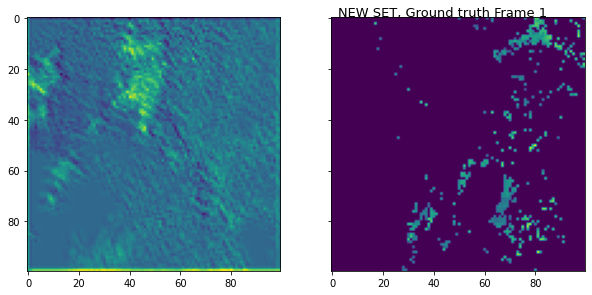

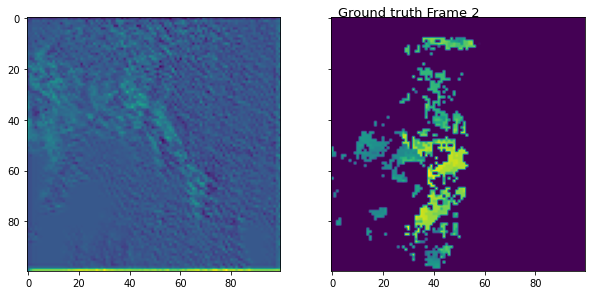

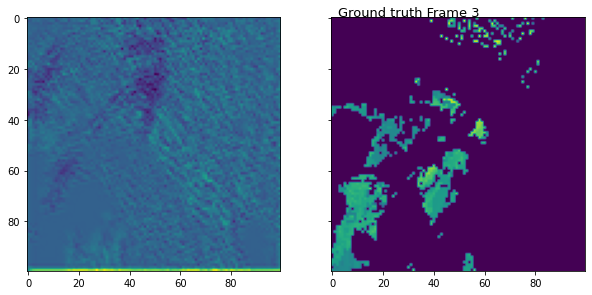

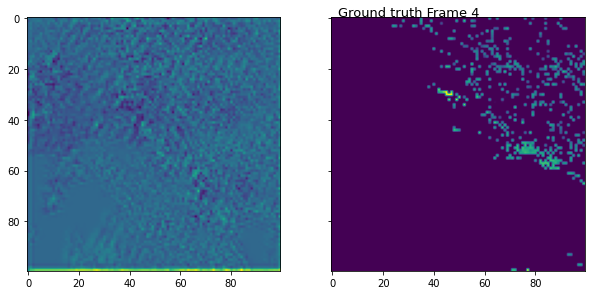

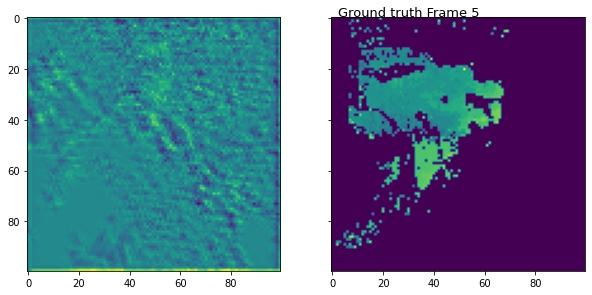

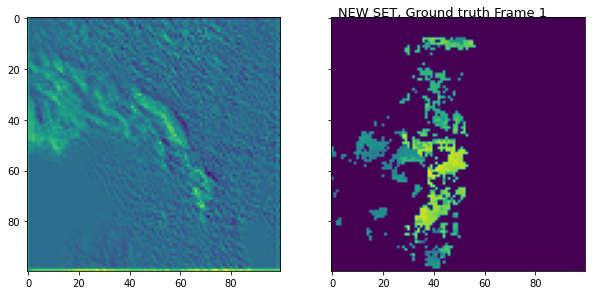

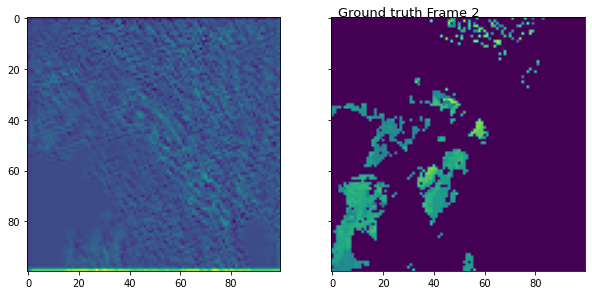

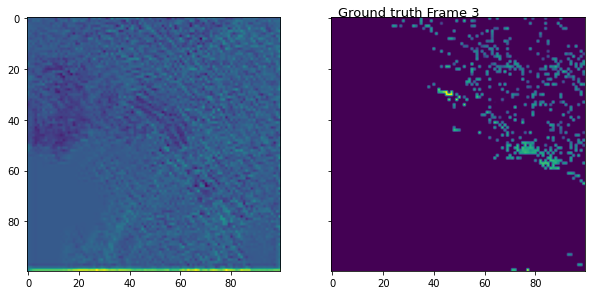

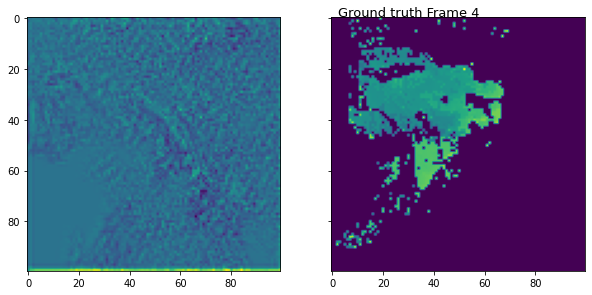

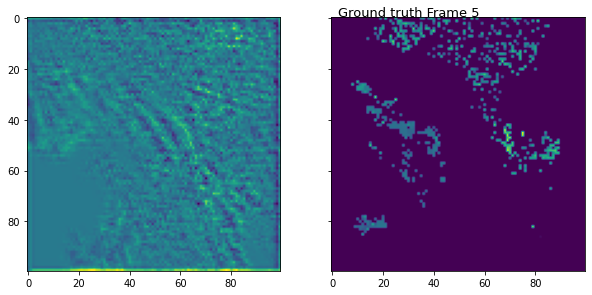

In [ ]:
visulization(y_test, Y_hat, 2)